# <center> Unit 1 - Ensemble Learning practical work
## <center> Hotel booking demand Classification

In this report, we would like to address some concepts / principles that were presented during the firs unit of the course
In order to do so, we chose to analyze the `hotel_booking_demand` dataset, and use it for solving a multilabel classification problem we defined.
Since the classes populations are not equal, we had to deal unbalanced dataset practices, and specifically with Bootstrapping to oversample the minorities groups.
We used multiple ensemble-based classifiers and compared their overall scores, efficiency and plotted their overfit/generalization tendency as a function of the model complexity
along with the bias/variance of the optimal hyperparam


In [249]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings

warnings.filterwarnings('ignore')

## EDA

In [250]:
df = pd.read_csv('data/hotel_bookings.csv')
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [251]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [252]:
df.shape

(119390, 32)

In [253]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [254]:
columns_mapping = {
    'hotel': '(H1 = Resort Hotel or H2 = City Hotel)',
    'is_canceled': 'Value indicating if the booking was canceled (1) or not (0)',
    'lead_time': 'Number of days that elapsed between the entering date of the booking into the PMS and the arrival date',
    'arrival_date_year': 'Year of arrival date',
    'arrival_date_month': 'Month of arrival date',
    'arrival_date_week_number': 'Week number of year for arrival date',
    'arrival_date_day_of_month': 'Day of arrival date',
    'stays_in_weekend_nights': 'Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel',
    'stays_in_week_nights': 'Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel',
    'adults': 'Number of adults',
    'children': 'Number of children',
    'babies': 'Number of babies',
    'meal': 'Type of meal booked. Categories are presented in standard hospitality meal packages:\nUndefined/SC – no meal package; BB – Bed & Breakfast;\nHB – Half board (breakfast and one other meal – usually dinner);\nFB – Full board (breakfast, lunch and dinner)',
    'country': 'Country of origin. Categories are represented in the ISO 3155–3:2013 format',
    'market_segment': 'Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”',
    'distribution_channel': 'Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”',
    'is_repeated_guest': 'Value indicating if the booking name was from a repeated guest (1) or not (0)',
    'previous_cancellations': 'Number of previous bookings that were cancelled by the customer prior to the current booking',
    'previous_bookings_not_canceled': 'Number of previous bookings not cancelled by the customer prior to the current booking',
    'reserved_room_type': 'Code of room type reserved. Code is presented instead of designation for anonymity reasons.',
    'assigned_room_type': 'Code for the type of room assigned to the booking.\nSometimes the assigned room type differs from the reserved room type due to hotel operation reasons\n(e.g. overbooking) or by customer request.\nCode is presented instead of designation for anonymity reasons.',
    'booking_changes': 'Number of changes/amendments made to the booking\nfrom the moment the booking was entered on the PMS until the moment of check-in or cancellation',
    'deposit_type': 'Indication on if the customer made a deposit to guarantee the booking.\nThis variable can assume three categories:\nNo Deposit – no deposit was made;\nNon Refund – a deposit was made in the value of the total stay cost;\nRefundable – a deposit was made with a value under the total cost of stay.',
    'agent': 'ID of the travel agency that made the booking',
    'company': 'ID of the company/entity that made the booking or responsible for paying the booking.\nID is presented instead of designation for anonymity reasons',
    'days_in_waiting_list': 'Number of days the booking was in the waiting list before it was confirmed to the customer',
    'customer_type': 'Type of booking, assuming one of four categories:\nContract - when the booking has an allotment or other type of contract associated to it;\nGroup – when the booking is associated to a group;\nTransient – when the booking is not part of a group or contract, and is not associated to other transient booking;\nTransient-party – when the booking is transient, but is associated to at least other transient booking',
    'adr': 'Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights',
    'required_car_parking_spaces': 'Number of car parking spaces required by the customer',
    'total_of_special_requests': 'Number of special requests made by the customer (e.g. twin bed or high floor)',
    'reservation_status': 'Reservation last status, assuming one of three categories:\nCanceled – booking was canceled by the customer;\nCheck-Out – customer has checked in but already departed;\nNo-Show – customer did not check-in and did inform the hotel of the reason why',
    'reservation_status_date': 'Date at which the last status was set.\nThis variable can be used in conjunction with the ReservationStatus to understand\nwhen was the booking canceled or when did the customer checked-out of the hotel'
}

Look for missing values and omit the containing rows

In [255]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

We see that `company` has many missing values, so we drop the column entirely
We replace agent `null` values with `0` to represent `null`
We set the missing countries as a `XXX` code
We drop the rows with missing `children` values

In [256]:
clean_df = df.fillna(value={'agent': 0, 'country': 'XXX'}).drop(columns='company')
clean_df = clean_df.dropna(axis=0, subset=['children'])
clean_df.isna().sum().sum()

0

In [257]:
df = clean_df

We split the columns to boolean, numerical and categorical ones for the analysis

In [258]:
bool_cols = ['is_repeated_guest', 'is_canceled']
numeric_cols = [col for col in df.columns if df[col].dtype in (int, float) and col not in bool_cols]
cat_cols = [col for col in df.columns if col not in numeric_cols and col not in bool_cols]

It seems that predicting the reservation status before it was closed can be a useful insight to the hotel managers.
**So we define a multi-class classification problem to predict the `reservation_status`**
We do notice that these classes populations are imbalanced and we will address that later on

In [259]:
df.reservation_status.value_counts()

Check-Out    75166
Canceled     43013
No-Show       1207
Name: reservation_status, dtype: int64

In [260]:
df['reservation_status'].value_counts() / df.shape[0]

Check-Out    0.629605
Canceled     0.360285
No-Show      0.010110
Name: reservation_status, dtype: float64

Running an auto-analysis tool for preliminary statistical examination of the features

In [261]:
import sweetviz as sv

analyze_report = sv.analyze(df)
analyze_report.show_html('analyze.html', open_browser=False)

### First impression:

our classification problem - predict the `reservation_status` of a given booking
`is_canceled` is highly correlated with our label, and is probably unavailable during prediction time, so we omit that column as well (since business-wise it is unknown given a new instance for prediction)
There seem to be some categorical/numerical/boolean columns that might have a significant signal for predicting `reservation_status`, so we would plot each ine of them and look for significant change groups reservation status

The following columns are pairwise correlated:
* stays_in_weekend_nights / stays_in_week_nights

In [262]:
df = df.drop(columns=['is_canceled']).dropna(axis=0)
bool_cols.remove('is_canceled')

#### Categorical data analysis

''

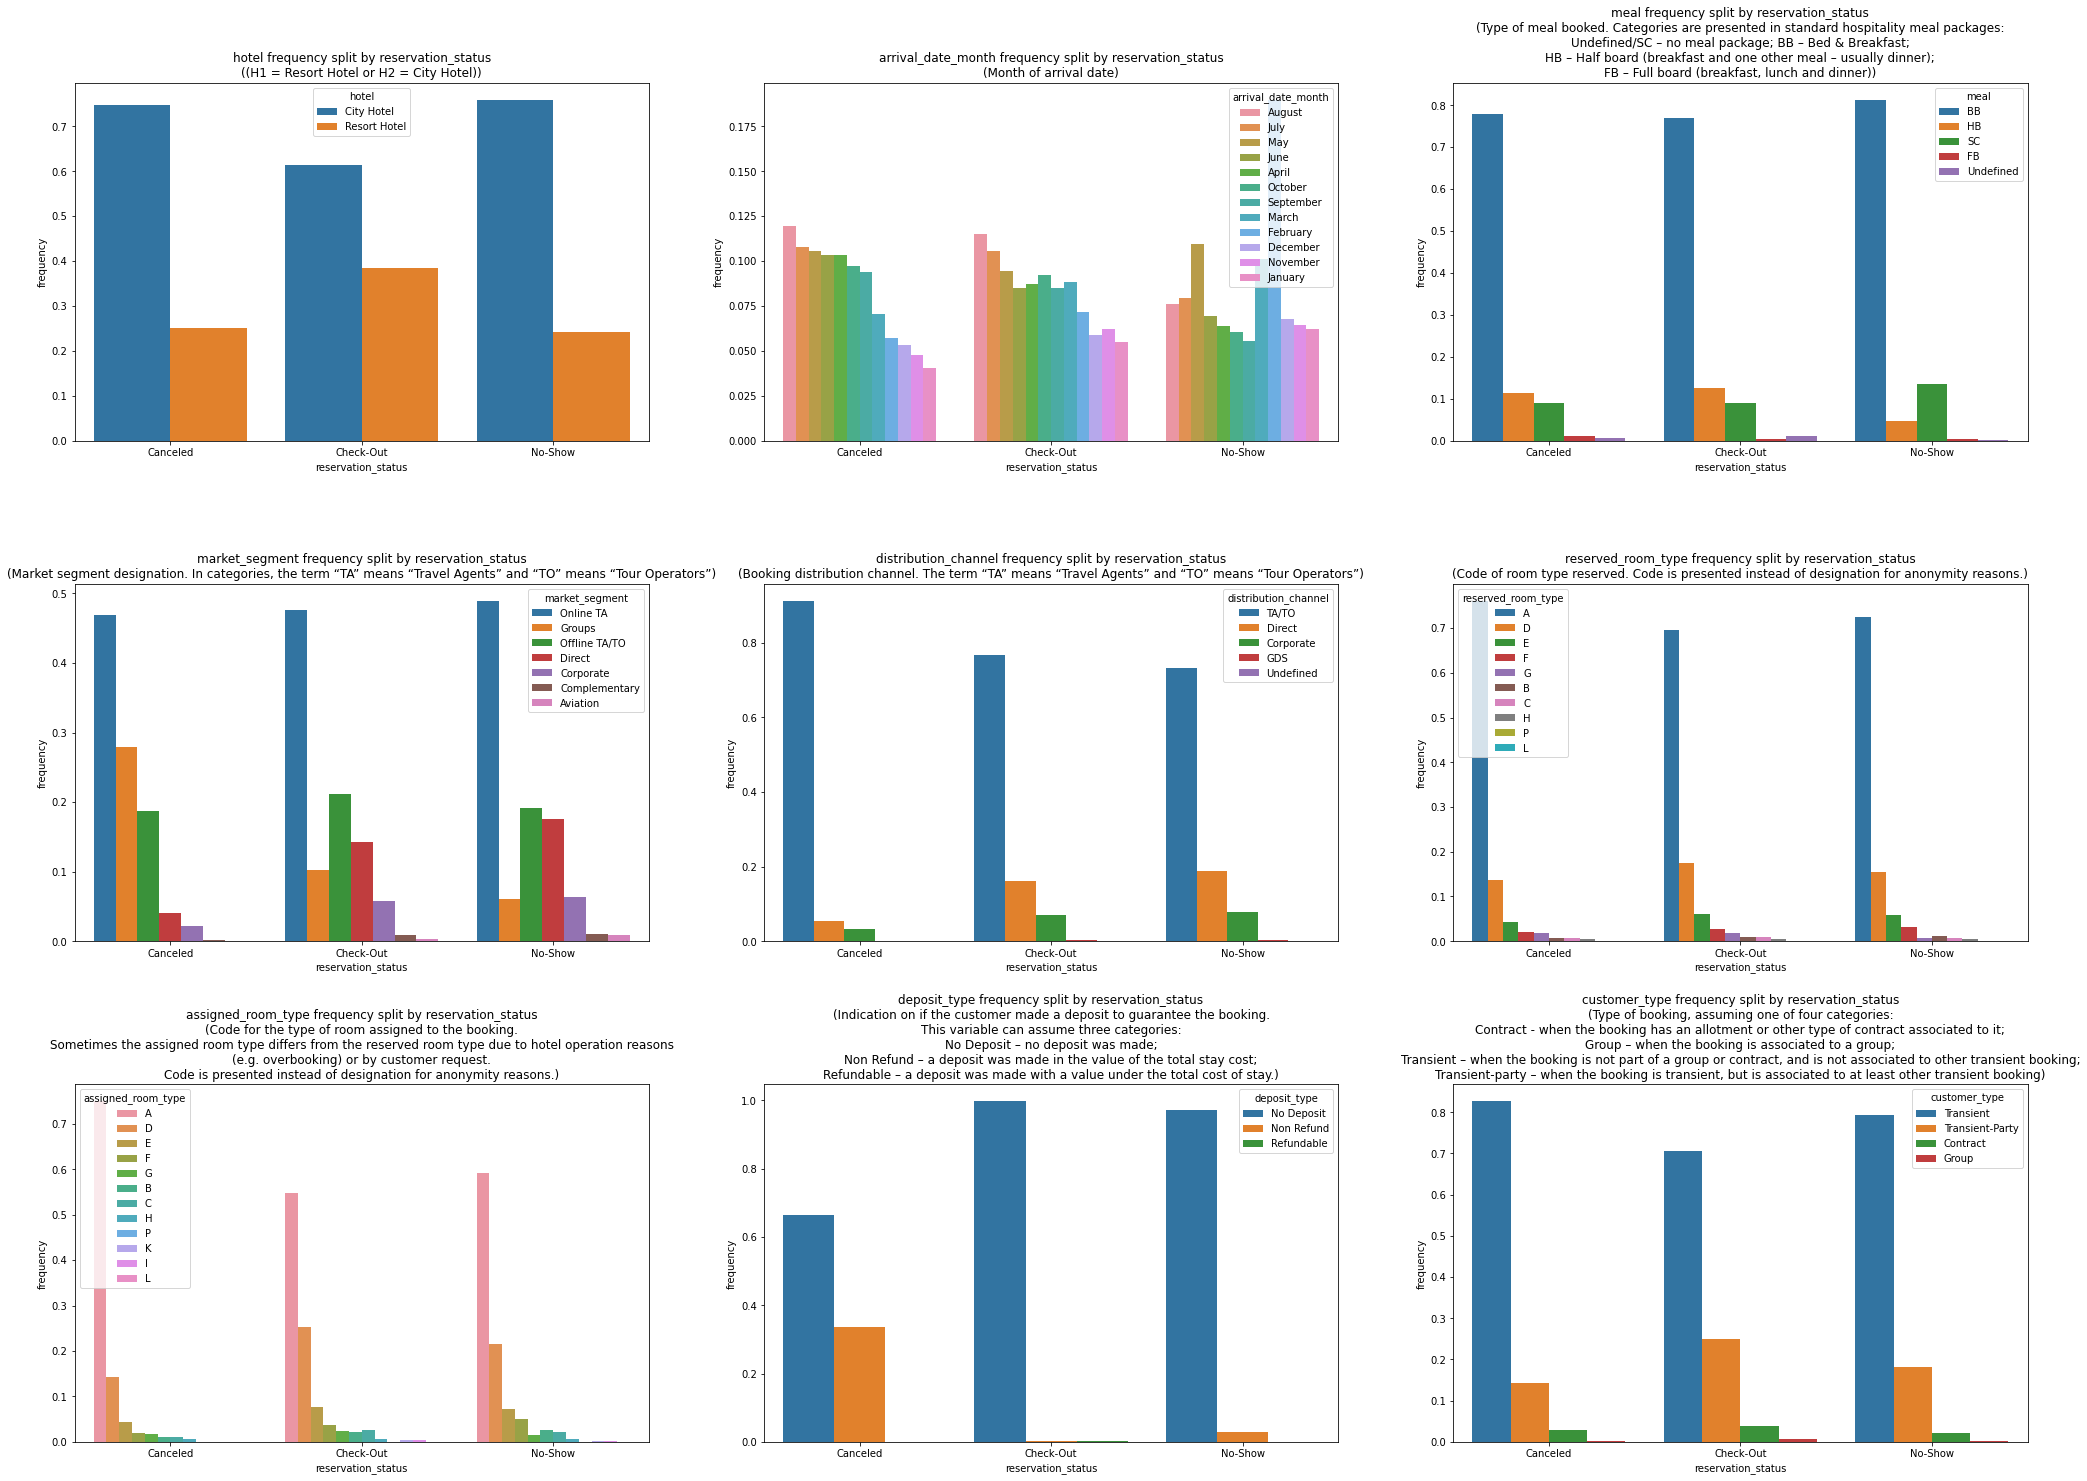

In [263]:
from matplotlib.pyplot import subplots_adjust

m = len(cat_cols)
plot_col_n = 3
_, ax = plt.subplots(3, plot_col_n, figsize=(35, 25))
subplots_adjust(hspace=0.4)
i = 0
for col in cat_cols:
    if col not in ['reservation_status', 'reservation_status_date', 'country']:
        _ax = ax[i // plot_col_n][i % plot_col_n]
        x, y = 'reservation_status', col
        plot_data = df.groupby(x)[y].value_counts(normalize=True).rename('frequency').reset_index()
        sns.barplot(data=plot_data, x=x, y='frequency', hue=y, ax=_ax)
        _ax.set(title=f'{col} frequency split by reservation_status\n({columns_mapping.get(col)})')
        i += 1
;

We can see that `deposit_type`, `hotel`, `distribution_channel`, `market_segment`, and `assigned_room_type` contain some signal as to the label
We encode the categorical features to identify correlations with the target label.

In [264]:
cat_cols = [col for col in cat_cols if col not in ['arrival_date_month', 'reservation_status_date']]
df_cat = df.copy()[cat_cols]
for col in cat_cols:
    df_cat[col] = df[col].astype('category').cat.codes

In [265]:
df_cat[cat_cols].head(5)

,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
0,1,0,135,3,1,2,2,0,2,1
1,1,0,135,3,1,2,2,0,2,1
2,1,0,59,3,1,0,2,0,2,1
3,1,0,59,2,0,0,0,0,2,1
4,1,0,59,6,3,0,0,0,2,1


In [266]:
def plot_heatmaps(data: pd.DataFrame, figsize=(20, 10)):
    for name, method in [('pearson', pearsonr),
                         ('spearman', spearmanr)]:
        print('********************************************************************\n')
        print(f'{name}\n')
        _, ax = plt.subplots(1, figsize=figsize)
        sns.heatmap(data.corr(method=name).abs(), annot=True, ax=ax)
        ax.set(title=f'Abs {name} correlations values')
        print(f'correlations')
        print(data.corr(method=name))
        print(f'\np-value')
        print(data.corr(method=lambda x, y: method(x, y)[1]))

********************************************************************

pearson

correlations
                         hotel      meal   country  market_segment  \
hotel                 1.000000 -0.008031  0.050496       -0.083783   
meal                 -0.008031  1.000000 -0.089888        0.145150   
country               0.050496 -0.089888  1.000000       -0.273398   
market_segment       -0.083783  0.145150 -0.273398        1.000000   
distribution_channel -0.174390  0.116990 -0.135407        0.767776   
reserved_room_type    0.249680 -0.120749 -0.100142        0.094543   
assigned_room_type    0.307833 -0.120796 -0.074357        0.026382   
deposit_type         -0.159031 -0.092158  0.320834       -0.184846   
customer_type        -0.047498  0.044686  0.025932       -0.165859   
reservation_status    0.124305  0.015371 -0.240847       -0.061560   

                      distribution_channel  reserved_room_type  \
hotel                            -0.174390            0.249680   
meal 

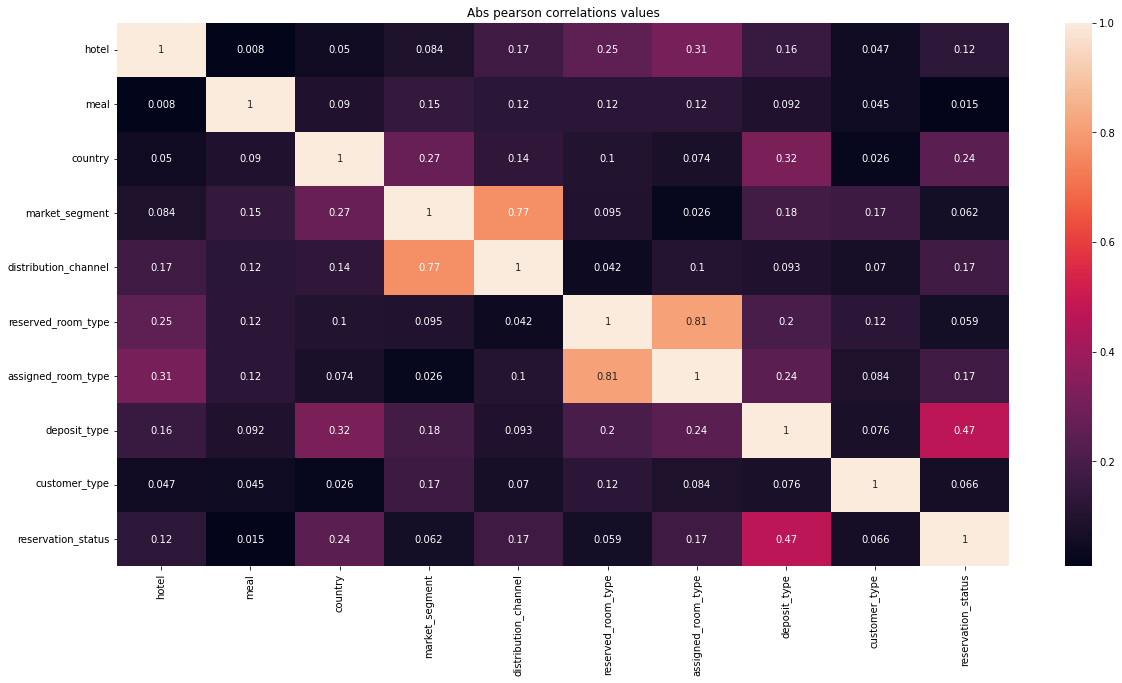

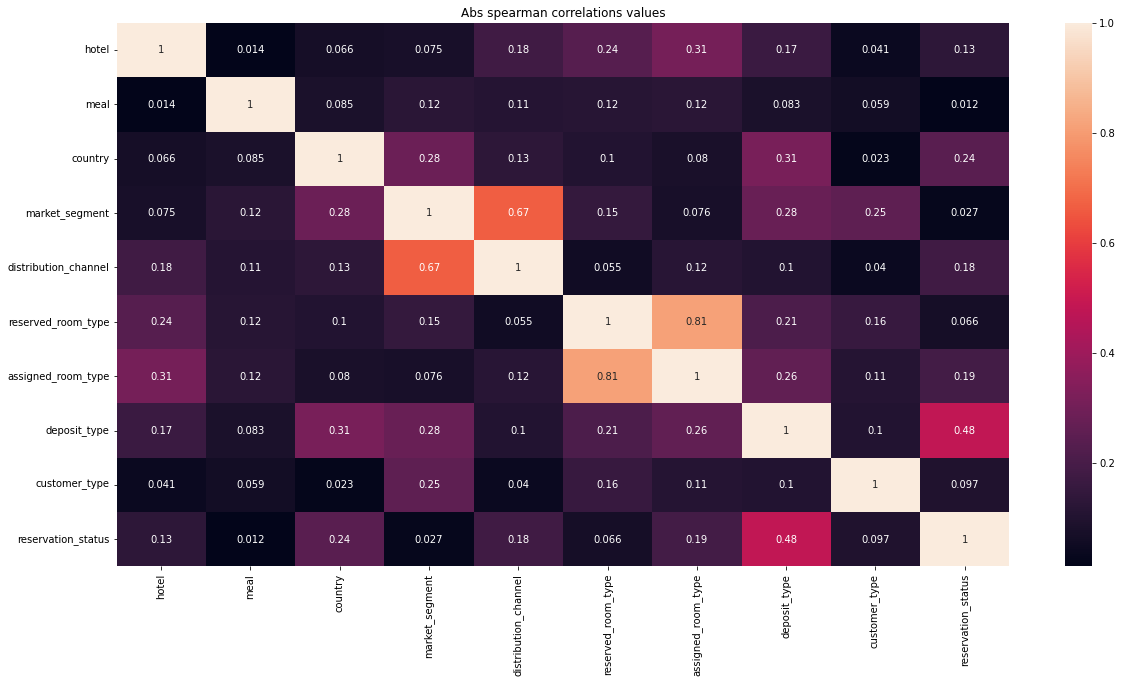

In [267]:
plot_heatmaps(df_cat)

#### CAT data - Conclusion
We can see with good confidence (very low p-val) that `deposit_type` has strong correlation to the reservation status, along with additional `assigned_room_type` `distribution_channel`, `country` and `hotel`

#### Numerical Data analysis

''

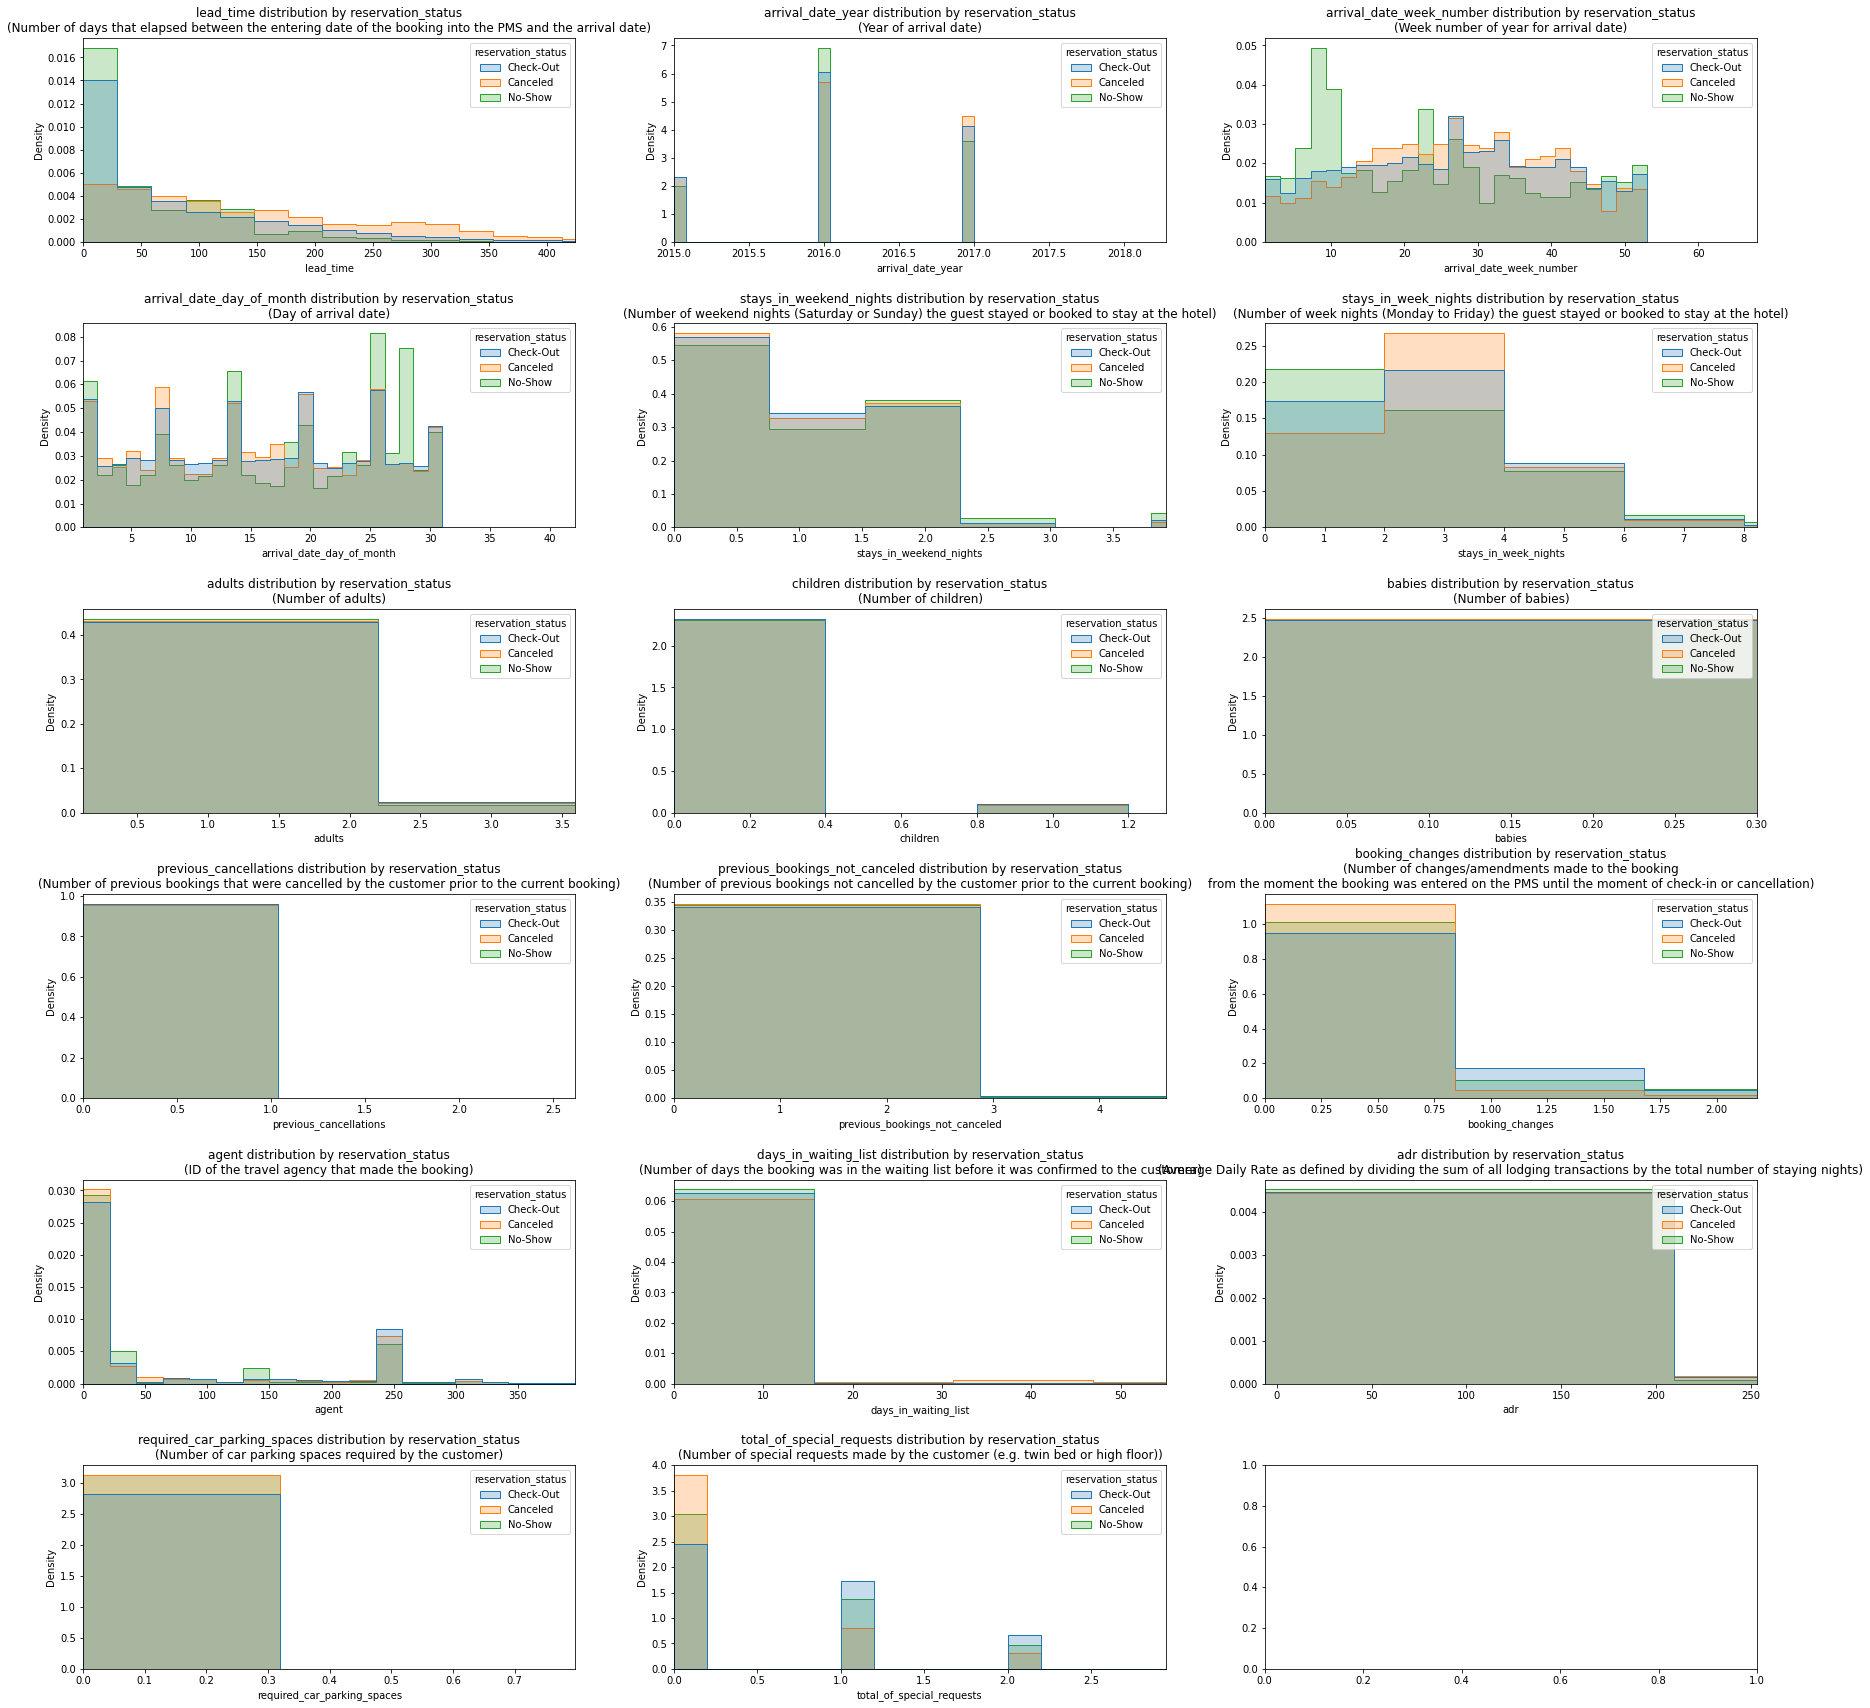

In [268]:
m = len(cat_cols)
plot_col_n = 3
_, ax = plt.subplots(6, plot_col_n, figsize=(30, 30))
subplots_adjust(hspace=0.4)
i = 0
for col in numeric_cols:
    _ax = ax[i // plot_col_n][i % plot_col_n]
    d = df[col].values
    sns.histplot(data=df, x=col, ax=_ax, hue='reservation_status', element="step", stat="density", common_norm=False,
                 bins=25)
    _ax.set(title=f'{col} distribution by reservation_status\n({columns_mapping.get(col)})')
    _ax.set_xlim(max(np.min(d), np.mean(d) - 3 * np.std(d)), np.mean(d) + 3 * np.std(d))
    i += 1
;

We can spot in the shared histograms above that `lead_time`, `booking_changes` and `total_special_requests` behave differently among the classes, and might have a significant signal to investigate

********************************************************************

pearson

correlations
                                lead_time  arrival_date_year  \
lead_time                        1.000000           0.040093   
arrival_date_year                0.040093           1.000000   
arrival_date_week_number         0.126885          -0.540566   
arrival_date_day_of_month        0.002234          -0.000279   
stays_in_weekend_nights          0.085667           0.021489   
stays_in_week_nights             0.165799           0.030878   
adults                           0.119544           0.029674   
children                        -0.037622           0.054624   
babies                          -0.020918          -0.013197   
previous_cancellations           0.086040          -0.119833   
previous_bookings_not_canceled  -0.073552           0.029214   
booking_changes                  0.000138           0.030855   
agent                           -0.012661           0.056431   
days_in_wait

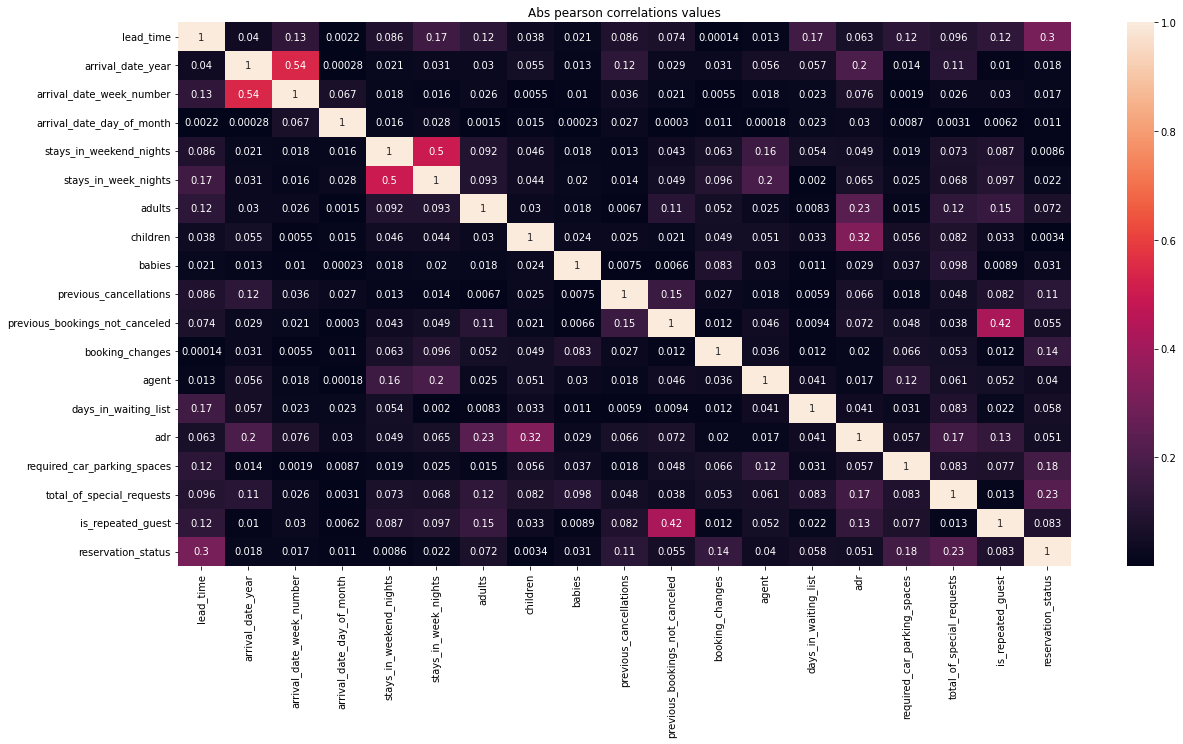

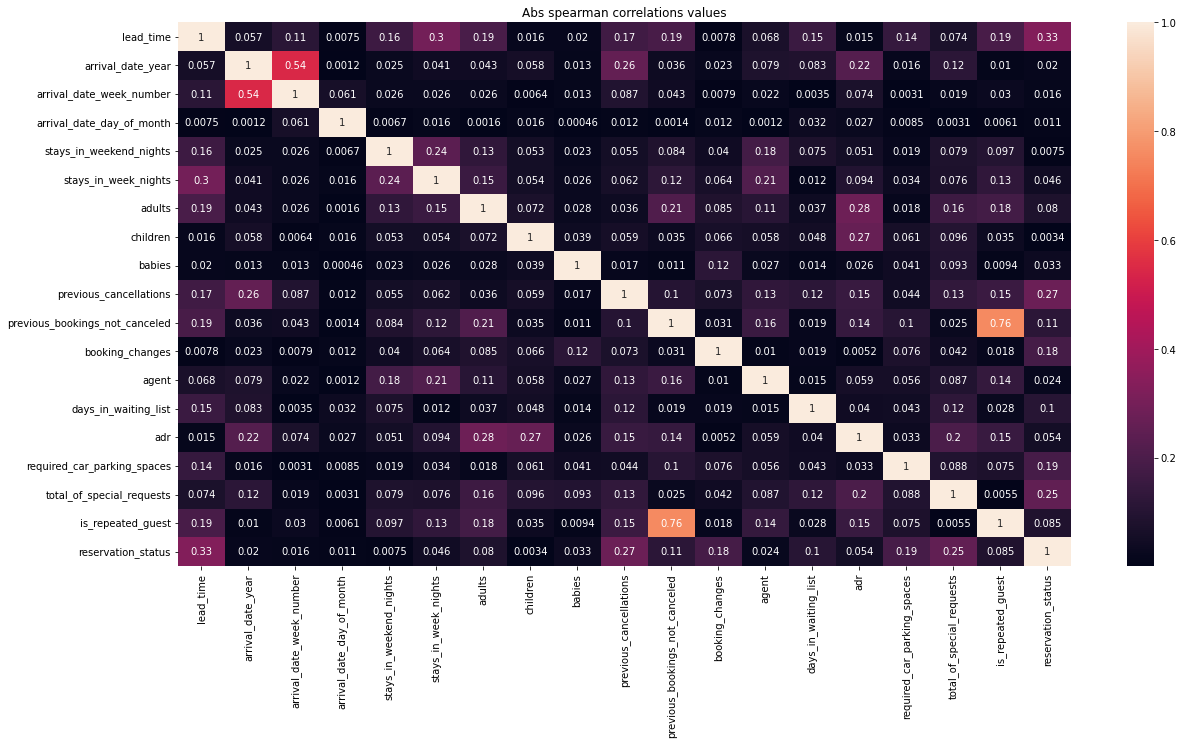

In [269]:
df_num = df.copy()[numeric_cols + bool_cols]
df_num['reservation_status'] = df['reservation_status'].astype('category').cat.codes
plot_heatmaps(df_num)

#### NUM data - conclusion
We can see with good confidence (very low p-val) that `lead_time` has strong correlation to the reservation status, along with additional `previous_cancellations` `booking_changes`, `required_car_parking_sapce`, `days_in_waiting_list`, and `total_special_requests`

#### Boolean data
We construct a new column `is_room_type_changed` that indicates if the hotel assigned a different room type than the one reserved by the client
We could see significant differences between the frequencies of the No-Show and Check-Out populations to that of the Cancled, when it comes to room type changing

In [270]:
def plot_boolean_feature(feature):
    _, ax = plt.subplots(1, 1, figsize=(12, 7))
    x, y = 'reservation_status', feature
    plot_data = df.groupby(x)[y].value_counts(normalize=True).rename('frequency').reset_index()
    sns.barplot(data=plot_data, x=x, y='frequency', hue=y, ax=ax)
    ax.set(title=f'{y} frequency split by reservation_status\n{columns_mapping.get(y, "")}');

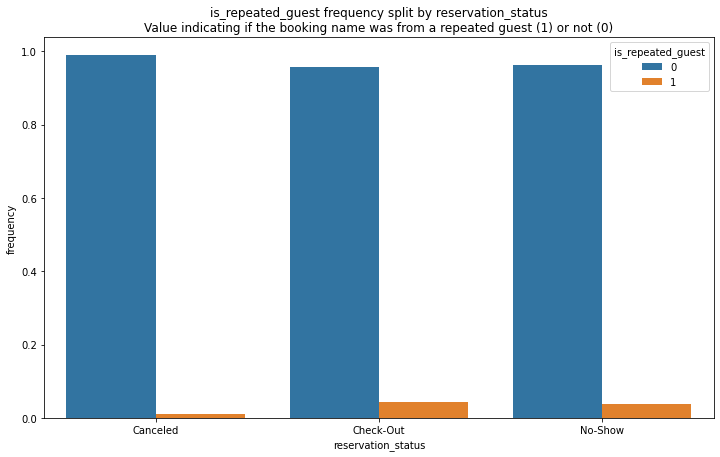

In [271]:
plot_boolean_feature('is_repeated_guest')

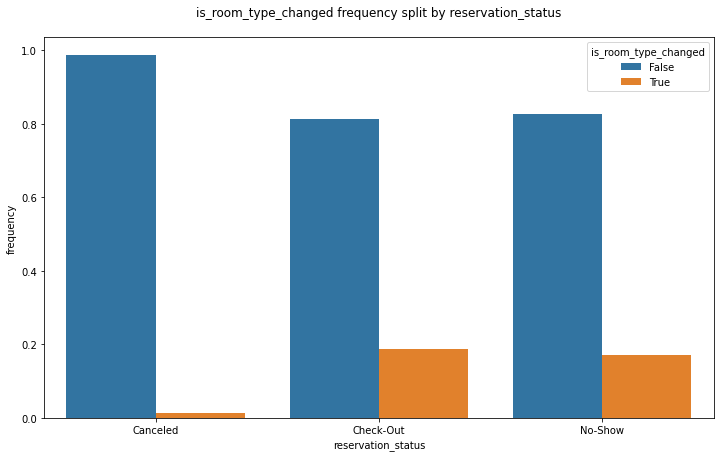

In [272]:
df['is_room_type_changed'] = df['reserved_room_type'] != df['assigned_room_type']
bool_cols.append('is_room_type_changed')
plot_boolean_feature('is_room_type_changed');

********************************************************************

pearson

correlations
                      is_repeated_guest  is_room_type_changed  \
is_repeated_guest              1.000000              0.084158   
is_room_type_changed           0.084158              1.000000   
reservation_status             0.083498              0.246187   

                      reservation_status  
is_repeated_guest               0.083498  
is_room_type_changed            0.246187  
reservation_status              1.000000  

p-value
                      is_repeated_guest  is_room_type_changed  \
is_repeated_guest          1.000000e+00         1.494877e-186   
is_room_type_changed      1.494877e-186          1.000000e+00   
reservation_status        1.170788e-183          0.000000e+00   

                      reservation_status  
is_repeated_guest          1.170788e-183  
is_room_type_changed        0.000000e+00  
reservation_status          1.000000e+00  
*********************************

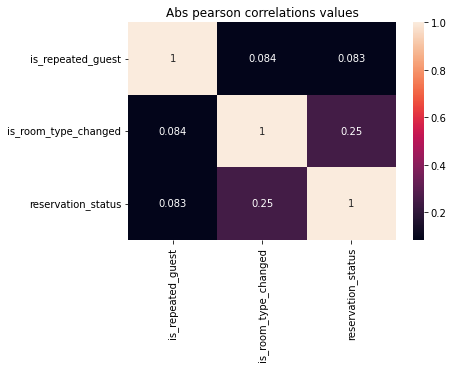

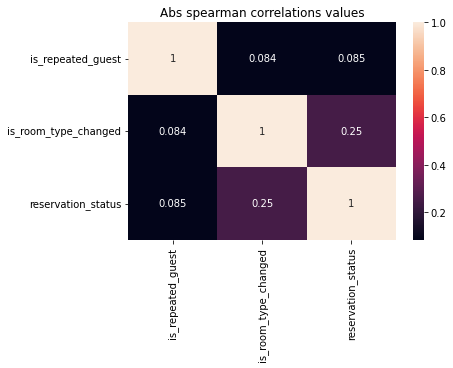

In [273]:
df_bool = df.copy()[bool_cols]
df_bool['reservation_status'] = df['reservation_status'].astype('category').cat.codes
plot_heatmaps(df_bool, figsize=(6, 4))

#### BOOL data - conclusion
We can see with good confidence (very low p-val) that `is_room_type_changesd` has strong correlation to the reservation status, which is a new col we generated stating if there was a change is the room assigned for the visitor, in comparison to the initially reserved room type.

#### Time Series
We try to look if there is any time-series signal that can be shown from the data. So we generate an `arrival_date` column and plot the `reservation_status` count for reservation that were to arrive that day

In [274]:
months = list(df.arrival_date_month.unique())
month_map = {months[i]: (i + 7) % 12 for i in range(0, 12)}
month_map['December'] = 12
df['arrival_date'] = df.apply(
    lambda row: pd.Timestamp(day=int(row.arrival_date_day_of_month), month=month_map[row.arrival_date_month],
                             year=int(row.arrival_date_year)), axis=1)

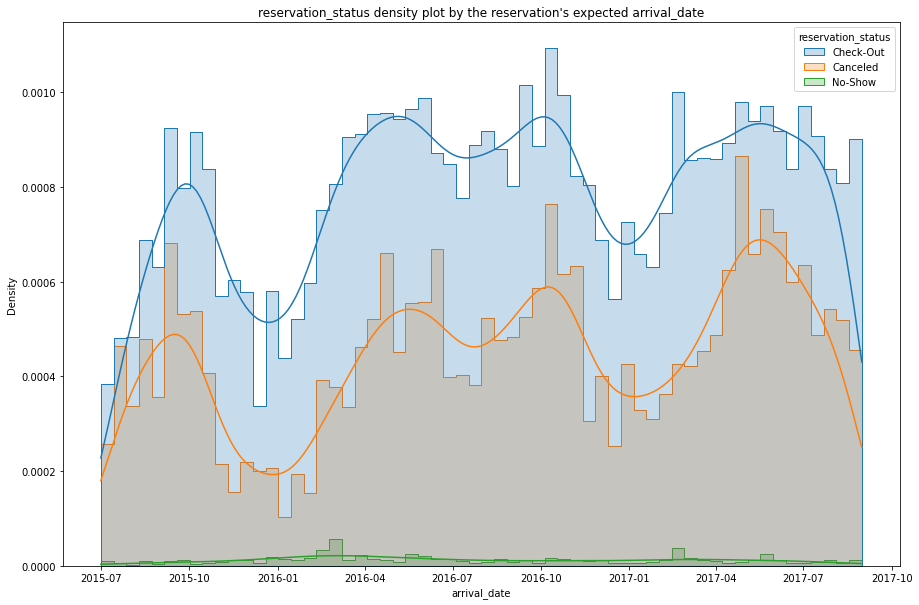

In [275]:
_, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set(title='reservation_status density plot by the reservation\'s expected arrival_date')
sns.histplot(data=df, x='arrival_date', hue='reservation_status', bins=60, ax=ax, stat='density', element='step',
             kde=True);

There is some seasonality with respect to the reservation status, yet it seems more likely because of the total seasonal demand for hotel rooms, while we can see the the difference between the 3 `reservation_type` population remains similar throughout the timeline
We infer though that there is not strong signal here for label prediction

Next, we plot 2 of the most correlated features with the target label: `lead_time` and `deposit_type`

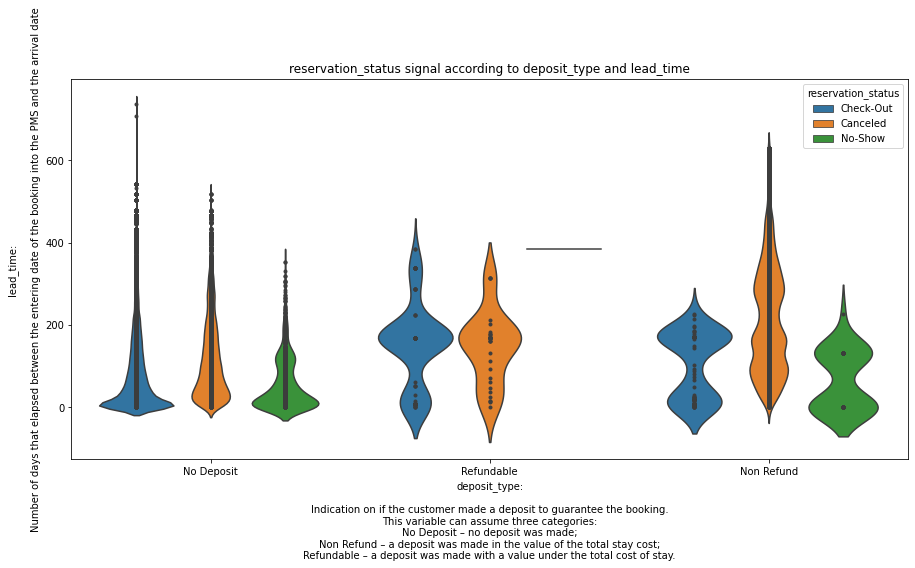

In [276]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.violinplot(data=df, x='deposit_type', y='lead_time', hue='reservation_status', ax=ax, inner='point')
ax.set(
    title=f'reservation_status signal according to deposit_type and lead_time',
    xlabel=f'deposit_type:\n\n{columns_mapping["deposit_type"]}',
    ylabel=f'lead_time:\n\n{columns_mapping["lead_time"]}'
);

This shows some very interesting results:
1. It seems that the majority of the `Non Refund` deposit type population had chosen to cancel its reservation - very surprising!
2. It looks like `Non Refund` also usually also involves a land leading time between the reservation data and the actual arrival data
3. Short `lead_time` are more common with `No Deposit` deposit population, and we do see that in general the shorter the lead, the less likely a reservation get canceled
4. We do not see any siginificant difference in the `Refundable` group. This can imply that `Refundable` deposits have little significance for CO/Cancellation, but does imply it is less likely to `No Show`

## Modeling

In [277]:
RANDOM_STATE = 42

In [278]:
def _generate_train_test(X, y):
    cat_cols = [
        'deposit_type',
        'market_segment',
        'assigned_room_type',
        'country',
        'hotel',
        'distribution_channel',
        'is_room_type_changed'
    ]

    X = X[
        [
            'lead_time',
            'booking_changes',
            'previous_cancellations',
            'previous_bookings_not_canceled',
            'days_in_waiting_list',
            'total_of_special_requests',
            'required_car_parking_spaces',
        ] + cat_cols
        ]

    for col in cat_cols:
        X[col] = X[col].astype('category').cat.codes

    return train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [279]:
def run_simulation(algo, iter_num, X, y, hyperparam, cv=3, **kwargs) -> list:
    scores = []
    for i in range(1, iter_num + 1):
        kwargs[hyperparam] = i
        model = algo(random_state=RANDOM_STATE, **kwargs)
        scores.append(np.mean(cross_val_score(model, X, y, cv=cv)))
    _, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.lineplot(y=scores, x=range(len(scores)), ax=ax)
    ax.set(title=f'{algo.__name__} training by {hyperparam} tweaking', xlabel=hyperparam, ylabel=f'{cv}-fold-cross-validation mean accuracy')
    return scores

In [280]:
def get_best_score(scores):
    best_score = max(scores)
    best_hyperparam = scores.index(best_score) + 1
    print(f'Achieved best score of {best_score} for iteration {best_hyperparam}')
    return best_hyperparam

In [281]:
def get_sorted_feature_importance(model):
    features_dict = {model.feature_names_in_[i]: model.feature_importances_[i] for i in range(model.n_features_in_)}
    return pd.Series({k: v for k, v in sorted(features_dict.items(), key=lambda item: item[1], reverse=True)})

In [282]:
def plot_norm_conf_matrix(fitted_model, X, y, normalize='true'):
    _, ax = plt.subplots(1, 1, figsize=(12, 7))
    ConfusionMatrixDisplay.from_estimator(estimator=fitted_model, X=X, y=y, normalize=normalize, ax=ax)
    ax.set(
        title=f'{fitted_model.__class__.__name__} test set confusion matrix\nnormalized over the {normalize} conditions');

In [283]:
def calc_metrics(model, X, y):
    metrics = precision_recall_fscore_support(y_true=y, y_pred=model.predict(X))
    return pd.DataFrame(metrics, index=['precision', 'recall', 'fscore', 'support'],
                        columns=['Canceled', 'Check-Out', 'No-Show']).T

In [284]:
def generate_train_test(df):
    X: pd.DataFrame = df.copy()
    y = X.pop('reservation_status')
    return _generate_train_test(X, y)

In [285]:
def print_bias_var(estimator, X_train, y_train, X_test, y_test):
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        estimator=estimator,
        X_train=X_train.values,
        y_train=y_train.astype('category').cat.codes.values,
        X_test=X_test.values,
        y_test=y_test.astype('category').cat.codes.values,
        loss='0-1_loss'
    )

    print(f'Average Expected Loss: {round(avg_expected_loss, 4)}')
    print(f'Average Bias: {round(avg_bias, 4)}')
    print(f'Average Variance: {round(avg_var, 4)}')

### In the following code, we trained DecisionTree, RandomForest, ADA Boost and Gradient Boost classifiers and exhibit the next:
1. We saw the overfitting tendency of decision trees by running a k-fold cross-validation training simulation and tweaking the `max-dpeth` param.
2. Other ensemble model showed little to no overfitting trends at all when adjusting their `n_estimators` hyperparam.
3. Then, we chose the best hyperparam according to the best average model accuracy during cross validation, and trained a classifier
4. For sanity, we print out the feature importance given by the fitted model, and as expected, the `deposit_type` and `lead_time` features were very correlative with the label on all algorithms used for modeling
5. We then printed out the confusion matrix, normalized by the predictions conditions, since business-wise we thought that precision is more important for hotel owners (hotel managers might want to take actions when the model predicts a cancellation or a No-Show, thus thus predictions should not have high False-Positive)
6. We also calculated the var/bias ratio of every trained model. The Variance was much higher for the decision tree classifier, where for all other ensemble classifiers trained, a similar variance was observed. Poor quality model showed high bias as expected.
7. We do see that model scores are effected by the fact that the dataset is unbalanced, since most No-Shows are with zero deposit fee, we next train another model, after resampling the data to achieve a balanced classed training set,

### Decision Tree

In [286]:
x_train, x_test, y_train, y_test = generate_train_test(df)

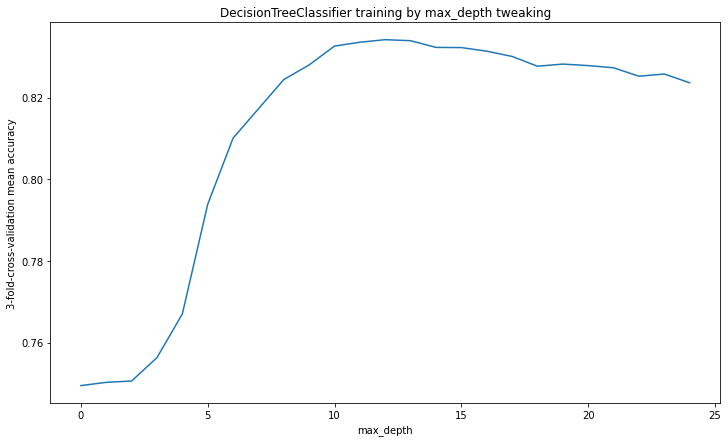

In [287]:
scores = run_simulation(
    algo=DecisionTreeClassifier,
    iter_num=25,
    hyperparam='max_depth',
    criterion='entropy',
    X=x_train,
    y=y_train
)

In [288]:
best_hyper_param = get_best_score(scores)

Achieved best score of 0.8341814298278679 for iteration 13


In [289]:
dtm = DecisionTreeClassifier(criterion='entropy', max_depth=best_hyper_param, random_state=RANDOM_STATE)

In [290]:
print_bias_var(dtm, x_train, y_train, x_test, y_test)

Average Expected Loss: 0.1654
Average Bias: 0.16
Average Variance: 0.0279


In [291]:
dtm.fit(x_train, y_train)
print(get_sorted_feature_importance(dtm))

deposit_type                      0.368377
market_segment                    0.128766
lead_time                         0.113627
country                           0.098339
is_room_type_changed              0.075591
total_of_special_requests         0.063218
required_car_parking_spaces       0.050116
previous_cancellations            0.039012
booking_changes                   0.021199
hotel                             0.012264
previous_bookings_not_canceled    0.012105
assigned_room_type                0.008647
distribution_channel              0.005791
days_in_waiting_list              0.002949
dtype: float64


In [292]:
print(f'model test score = {dtm.score(x_test, y_test)}')

model test score = 0.8379680040204373


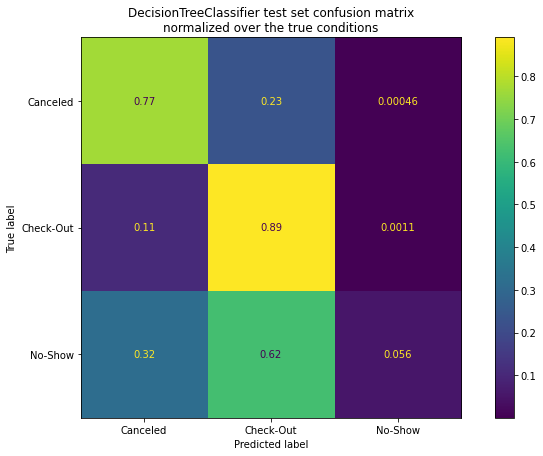

In [293]:
plot_norm_conf_matrix(fitted_model=dtm, X=x_test, y=y_test)

In [294]:
calc_metrics(dtm, X=x_test, y=y_test)

,precision,recall,fscore,support
Canceled,0.797341,0.767554,0.782164,8673.0
Check-Out,0.860803,0.890870,0.875578,14973.0
No-Show,0.393939,0.056034,0.098113,232.0


#### Decision Tree with Balanced Sampling

We over/under sample the label population by Bootstrapping
We can see that by oversampling randomly, we manged to get a much better recall score over the No-Show population, although it reduced the overall accuracy of the model.
We can also see a "better" cross-val scores when oversampling, since probably some duplicated instances exist in both train and validation sets.
Under-sampling didn't go well (probably the loss of the majority of samples caused the signal to weakened
So, we would choose to **oversample** the data in the next modeling phases if we are to gain a higher recall for No-Show population
Another interesting point to look at, is the bias / variance tradeoff when over/under sampling. We see that the undersampled model has high bias as expected since it

**Over sampling**

In [295]:
x_train, x_test, y_train, y_test = generate_train_test(df)
over_sampler = RandomOverSampler()
x_train, y_train = over_sampler.fit_resample(x_train, y_train)

In [296]:
y_train.value_counts() / y_train.shape[0]

Canceled     0.333333
Check-Out    0.333333
No-Show      0.333333
Name: reservation_status, dtype: float64

In [297]:
y_test.value_counts() / y_test.shape[0]

Check-Out    0.627063
Canceled     0.363221
No-Show      0.009716
Name: reservation_status, dtype: float64

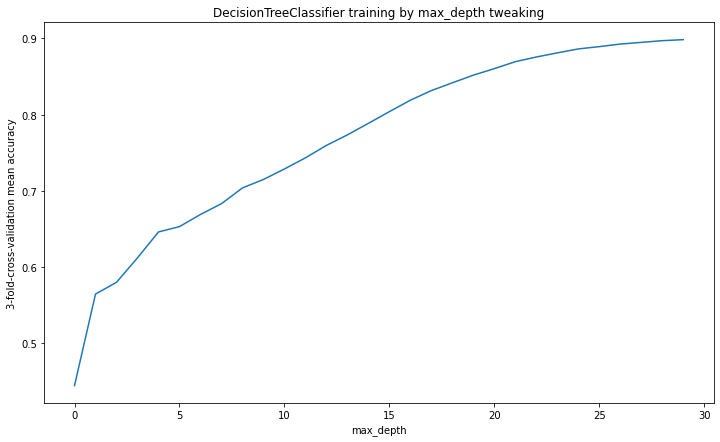

In [298]:
scores = run_simulation(
    algo=DecisionTreeClassifier,
    iter_num=30,
    hyperparam='max_depth',
    criterion='entropy',
    X=x_train,
    y=y_train
)

In [299]:
best_hyper_param = get_best_score(scores)

Achieved best score of 0.8983990386479048 for iteration 30


In [300]:
dtm = DecisionTreeClassifier(criterion='entropy', max_depth=best_hyper_param, random_state=RANDOM_STATE)

In [301]:
print_bias_var(dtm, x_train, y_train, x_test, y_test)

Average Expected Loss: 0.204
Average Bias: 0.1812
Average Variance: 0.0926


In [302]:
dtm.fit(x_train, y_train)
print(f'model test score = {dtm.score(x_test, y_test)}')

model test score = 0.8059301449032582


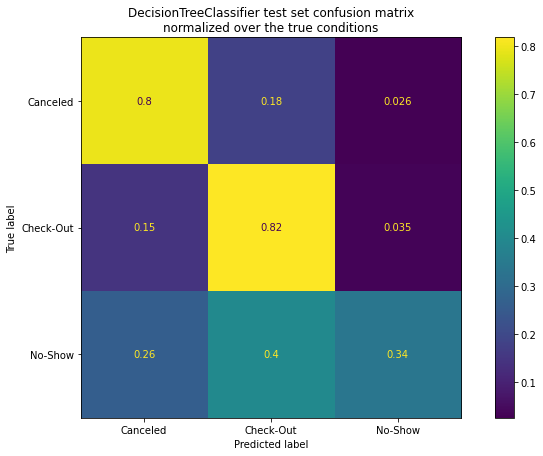

In [303]:
plot_norm_conf_matrix(fitted_model=dtm, X=x_test, y=y_test)

In [304]:
calc_metrics(dtm, X=x_test, y=y_test)

,precision,recall,fscore,support
Canceled,0.754426,0.795918,0.774617,8673.0
Check-Out,0.882230,0.819008,0.849444,14973.0
No-Show,0.094203,0.336207,0.147170,232.0


**Under sampling**

In [305]:
x_train, x_test, y_train, y_test = generate_train_test(df)
under_sampler = RandomUnderSampler()
x_train, y_train = under_sampler.fit_resample(x_train, y_train)

In [306]:
y_train.value_counts() / y_train.shape[0]

Canceled     0.333333
Check-Out    0.333333
No-Show      0.333333
Name: reservation_status, dtype: float64

In [307]:
y_test.value_counts() / y_test.shape[0]

Check-Out    0.627063
Canceled     0.363221
No-Show      0.009716
Name: reservation_status, dtype: float64

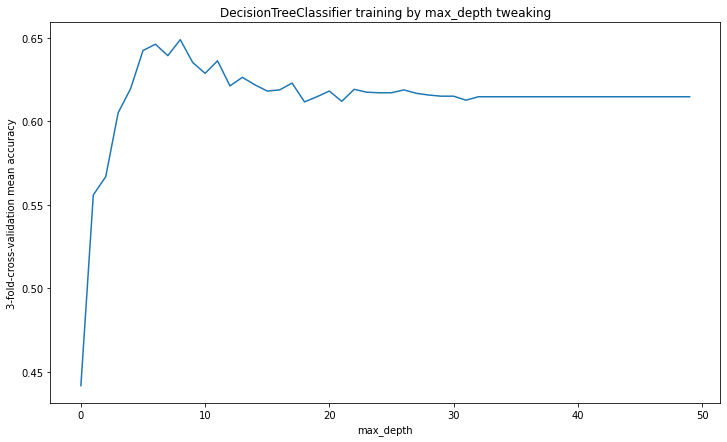

In [308]:
scores = run_simulation(
    algo=DecisionTreeClassifier,
    iter_num=50,
    hyperparam='max_depth',
    criterion='entropy',
    X=x_train,
    y=y_train
)

In [309]:
best_hyper_param = get_best_score(scores)

Achieved best score of 0.648888888888889 for iteration 9


In [310]:
dtm = DecisionTreeClassifier(criterion='entropy', max_depth=best_hyper_param, random_state=RANDOM_STATE)

In [311]:
print_bias_var(dtm, x_train, y_train, x_test, y_test)

Average Expected Loss: 0.3846
Average Bias: 0.3574
Average Variance: 0.1717


In [312]:
dtm.fit(x_train, y_train)
print(f'model test score = {dtm.score(x_test, y_test)}')

model test score = 0.652609096239216


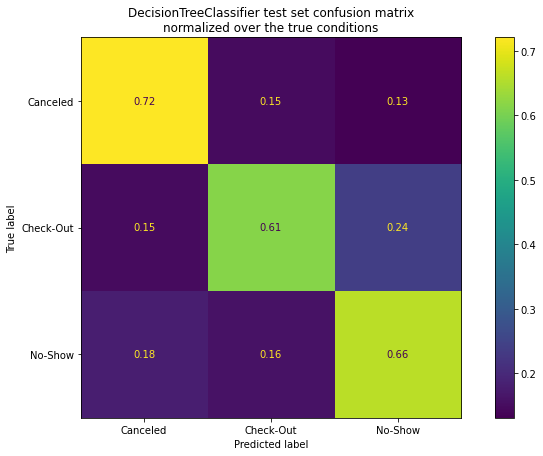

In [313]:
plot_norm_conf_matrix(fitted_model=dtm, X=x_test, y=y_test)

In [314]:
calc_metrics(dtm, X=x_test, y=y_test)

,precision,recall,fscore,support
Canceled,0.734751,0.720858,0.727738,8673.0
Check-Out,0.873846,0.612970,0.720521,14973.0
No-Show,0.031443,0.659483,0.060024,232.0


### Random Forest

We can see that for Random Forest, there is no overfitting when increasing the number of estimators
The classifier also seems to present better results to the singleton decision tree, although it uses much less complex trees for bagging (20 depth)
It presents low bias, and low variance

In [315]:
x_train, x_test, y_train, y_test = generate_train_test(df)

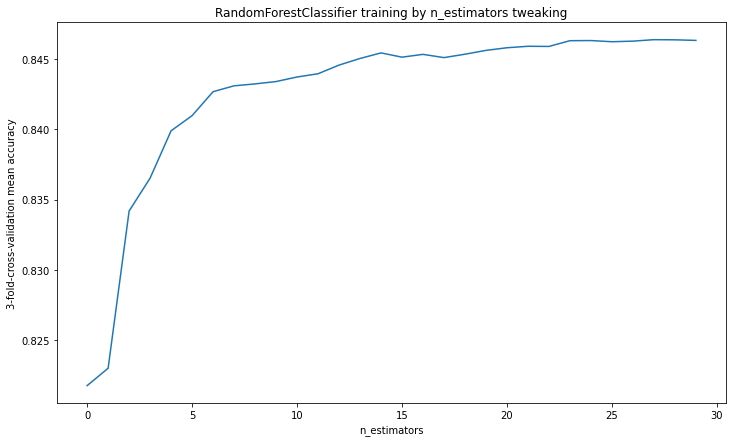

In [316]:
scores = run_simulation(
    algo=RandomForestClassifier,
    iter_num=30,
    hyperparam='n_estimators',
    criterion='entropy',
    max_depth=20,
    X=x_train,
    y=y_train
)

In [317]:
best_hyper_param = get_best_score(scores)

Achieved best score of 0.8463898312183273 for iteration 28


In [318]:
rfm = RandomForestClassifier(
    criterion='entropy',
    random_state=RANDOM_STATE,
    n_estimators=best_hyper_param,
    max_depth=20
)


In [319]:
print_bias_var(rfm, x_train, y_train, x_test, y_test)

Average Expected Loss: 0.1524
Average Bias: 0.1483
Average Variance: 0.0316


In [320]:
rfm.fit(x_train, y_train)
print(get_sorted_feature_importance(rfm))

lead_time                         0.225401
deposit_type                      0.165372
country                           0.157980
market_segment                    0.115158
total_of_special_requests         0.065591
is_room_type_changed              0.053687
previous_cancellations            0.043096
required_car_parking_spaces       0.041337
assigned_room_type                0.040029
booking_changes                   0.035955
distribution_channel              0.022705
hotel                             0.016512
previous_bookings_not_canceled    0.011416
days_in_waiting_list              0.005762
dtype: float64


In [321]:
print(f'model test score = {rfm.score(x_test, y_test)}')

model test score = 0.8526677276153781


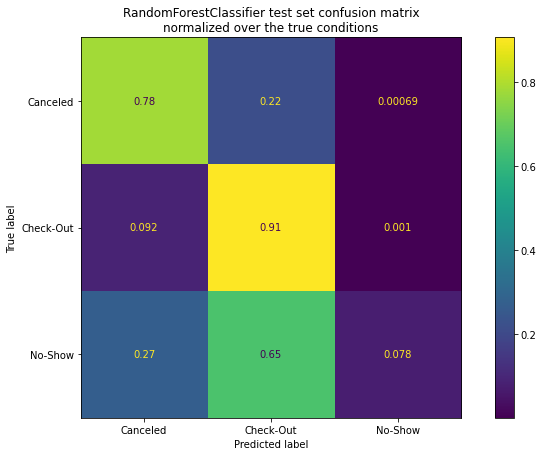

In [322]:
plot_norm_conf_matrix(fitted_model=rfm, X=x_test, y=y_test, normalize='true')

In [323]:
calc_metrics(rfm, X=x_test, y=y_test)

,precision,recall,fscore,support
Canceled,0.823780,0.780468,0.801539,8673.0
Check-Out,0.868839,0.906498,0.887269,14973.0
No-Show,0.461538,0.077586,0.132841,232.0


### ADABoosting

We can see that for ADABoost, there is overfitting when increasing the number of estimators
The classifier also seems to presents worse results than the Random Forest one.
Converge time is much better than in the Gradient Boosting classifier

In [324]:
x_train, x_test, y_train, y_test = generate_train_test(df)

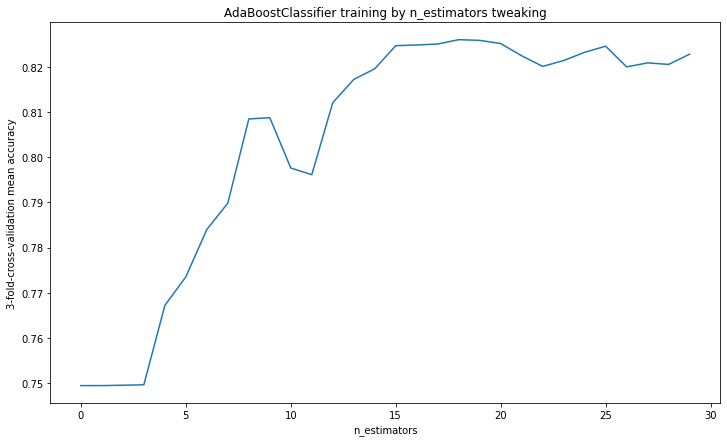

In [325]:
scores = run_simulation(
    algo=AdaBoostClassifier,
    iter_num=30,
    base_estimator=DecisionTreeClassifier(max_depth=1),
    hyperparam='n_estimators',
    X=x_train,
    y=y_train
)

In [326]:
best_hyper_param = get_best_score(scores)

Achieved best score of 0.8259936340411275 for iteration 19


In [327]:
abm = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=best_hyper_param)

In [328]:
print_bias_var(abm, x_train, y_train, x_test, y_test)

Average Expected Loss: 0.1758
Average Bias: 0.1692
Average Variance: 0.0287


In [329]:
abm.fit(x_train, y_train)
print(get_sorted_feature_importance(abm))

country                           0.315789
lead_time                         0.157895
deposit_type                      0.105263
booking_changes                   0.052632
previous_cancellations            0.052632
previous_bookings_not_canceled    0.052632
total_of_special_requests         0.052632
required_car_parking_spaces       0.052632
market_segment                    0.052632
hotel                             0.052632
is_room_type_changed              0.052632
days_in_waiting_list              0.000000
assigned_room_type                0.000000
distribution_channel              0.000000
dtype: float64


In [330]:
print(f'model test score = {abm.score(x_test, y_test)}')

model test score = 0.8282938269536813


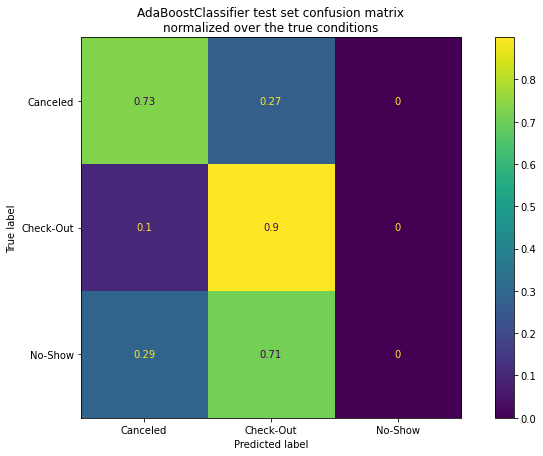

In [331]:
plot_norm_conf_matrix(fitted_model=abm, X=x_test, y=y_test, normalize='true')

In [332]:
calc_metrics(abm, X=x_test, y=y_test)

,precision,recall,fscore,support
Canceled,0.800330,0.727891,0.762394,8673.0
Check-Out,0.842089,0.899285,0.869748,14973.0
No-Show,0.000000,0.000000,0.000000,232.0


### Gradient Boosting

We can see that for Gradient Boost, there is overfitting when increasing the number of estimators
The classifier also seems to present slightly worse results than the Random Forest one and than ADA Boost.
Converge time is very long

In [333]:
x_train, x_test, y_train, y_test = generate_train_test(df)

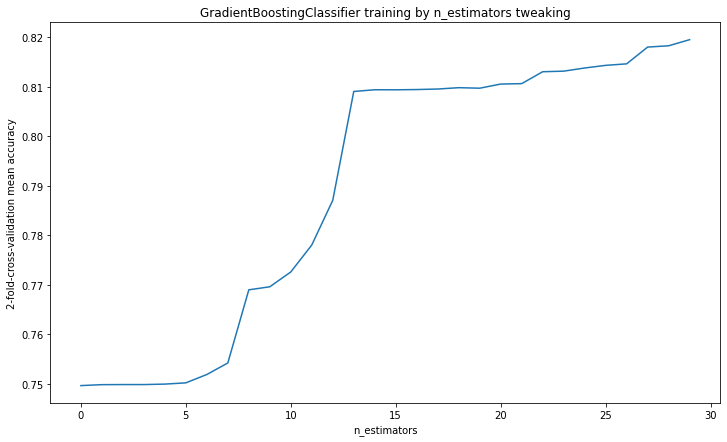

In [334]:
scores = run_simulation(
    algo=GradientBoostingClassifier,
    iter_num=30,
    hyperparam='n_estimators',
    init=DecisionTreeClassifier(max_depth=1),
    X=x_train,
    y=y_train,
    cv=2
)

In [335]:
best_hyper_param = get_best_score(scores)

Achieved best score of 0.8195543828789211 for iteration 30


In [336]:
gbm = GradientBoostingClassifier(n_estimators=best_hyper_param, init=DecisionTreeClassifier(max_depth=1))

In [337]:
print_bias_var(gbm, x_train, y_train, x_test, y_test)

Average Expected Loss: 0.1815
Average Bias: 0.1823
Average Variance: 0.0109


In [338]:
gbm.fit(x_train, y_train)
print(get_sorted_feature_importance(gbm))

market_segment                    0.226300
country                           0.165263
lead_time                         0.160868
is_room_type_changed              0.119097
total_of_special_requests         0.111344
required_car_parking_spaces       0.075196
previous_cancellations            0.043736
deposit_type                      0.038872
booking_changes                   0.029204
previous_bookings_not_canceled    0.028258
assigned_room_type                0.001783
hotel                             0.000076
distribution_channel              0.000004
days_in_waiting_list              0.000000
dtype: float64


In [339]:
print(f'model test score = {gbm.score(x_test, y_test)}')

model test score = 0.8185777703325237


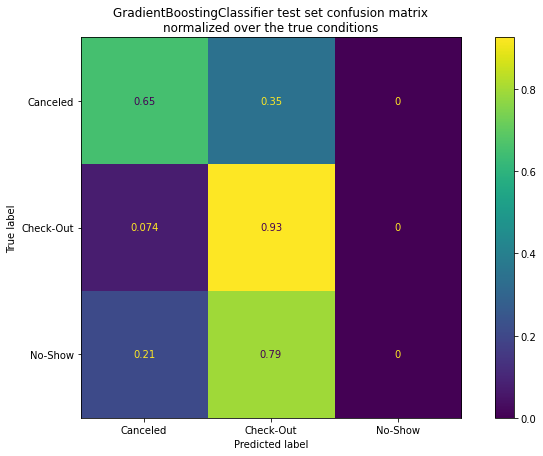

In [340]:
plot_norm_conf_matrix(fitted_model=gbm, X=x_test, y=y_test)

In [341]:
calc_metrics(gbm, X=x_test, y=y_test)

,precision,recall,fscore,support
Canceled,0.831114,0.654791,0.732491,8673.0
Check-Out,0.813552,0.926134,0.866200,14973.0
No-Show,0.000000,0.000000,0.000000,232.0
